**решающее дерево**

Евгений Борисов <esborisov@sevsu.ru>

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## загружаем данные

(512, 2)

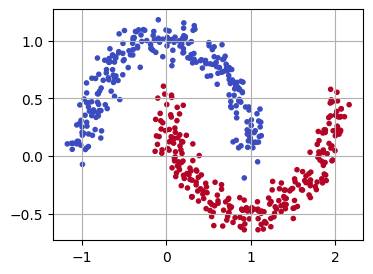

In [2]:
from sklearn.datasets import make_moons

X,target = make_moons(n_samples=512,noise=.09)
display( X.shape, )

fig,ax = plt.subplots( figsize=(4,3),)
ax.scatter(x=X[:,0],y=X[:,1],c=target, marker='.', cmap='coolwarm')
ax.grid()

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, target_train, target_test = train_test_split(X,target,test_size=.5)
display( X_train.shape, X_test.shape, )

assert len(target_train) == len(X_train)
assert len(target_test) == len(X_test)

del X,target

(256, 2)

(256, 2)

## критерий информативности

In [4]:
class Information:
    
    # считаем информативность предиката x>b для разметки t
    def score(x,b,t): pass

**энтропийный критерий - информационный выигрыш (Information gain)**

Пусть ω0, ω1 — два исхода с вероятностями $q$ и $1−q$    

Количество информации:  
    $$I_0 = − log_2(q)$$  
    $$I_1 = − log_2(1 − q)$$ 

Энтропия - математическое ожидание количества информации:  

$$h(q) = −q \cdot log_2(q) − (1−q)\cdot log_2(1 − q)$$

Энтропия выборки $X$, если исходы — это классы $y=c$, $y\neq c$:
$$H(y) = h\left( \frac{P(y)}{S} \right)$$
P(y) - количество позитивных объектов класса y

S - общее количество объектов

Энтропия выборки $X$ после получения информации $R$: 

$$H(y|R)=\frac{p+n}{S} \cdot h\left(\frac{p}{p+n}\right) + \frac{S-p-n}{S} \cdot h\left( \frac{P(y)-p}{S-p-n} \right)$$


Информационный выигрыш (Information gain):
$$iGain(y,R) = H(y) − H(y|R)$$



- S - общее количество объектов
- P - количество положительных примеров
- p - количество положительных примеров, выделеных предикатом
- n - количество отрицательных примеров, выделеных предикатом




In [5]:
class InformationGain:
    
    # считаем информативность предиката x>b для разметки t
    def score(self,x,b,t):
        assert len(x)>0
        assert len(x)==len(t)
        S = len(t) # общее количество примеров
        P_all = t.sum() # количество положительных примеров
        f = x>b #  отмечаем примеры выделенные предикатом 
        p = (t[f]==1).sum() # количество положительных примеров, выделенных предикатом   
        n = (t[f]==0).sum() # количество отрицательных примеров, выделенных предикатом
        return self._igain(S,P_all,p,n) # разница в информативности    
    
    # разница в информативности, до и после примения предиката
    @classmethod
    def _igain(cls,S,P_y,p,n):
        # S - количество примеров
        # P_y - количество положительных в классе y
        # p - количество положительных примеров, выделенных предикатом   
        # n - количество отрицательных примеров, выделенных предикатом
        return cls._h(P_y/S) - ( (p+n)/S * cls._h(p/(p+n)) + (S-p-n)/S * cls._h( (P_y-p)/(S-p-n)) )
    
    # энтропийный критерий - информационный выигрыш (Information gain, IGain):
    @staticmethod
    def _h(q):
        with np.errstate(divide='ignore',invalid='ignore'):
            l1 = np.where(q>0, q*np.log2(q), 0. )    
            l2 = np.where(q<1., (1.-q)*np.log2(1.-q), 0. )    
        return -l1 - l2


In [6]:
InformationGain().score( x=X_test[:,1], b=X_test[:,1].mean(), t=target_test)

0.38274552810075835

## строим модель

Алгоритм ID3 обучения модели DecisionTreeClassifier:

1. если X содержит точки только одного класса то создать лист с меткой класса и переход на п.6

2. выбрать признак номер $i$ и найти для него пороговое значение $b$, $(min(X_i) < b < max(X_i) )$ с максимальной информативностью разделения

3. создать узел дерева и сохранить там найденную пару $(i,b)$

4. разделить $X$ на две части по признаку $i$ и его порогу $b$

5. выполнить рекурсивно с п.1 для каждого полученного на пред.шаге подмножества

6. конец работы

In [7]:
class DecisionTreeClassifier:
    
    def __init__(self, info_crit=InformationGain()):
        self._info_crit = info_crit
        self._tree = dict()
        self._rules = lambda x: None
    
    def fit(self,X,target,nb=30): 
        self._tree = self._id3(X_train,target_train,nb=30)
        self._rules = self._tree2rules(self._tree)
        return self
        
        
    def _id3(self,X,target,nb=30): # строим решающее дерево
        if (target==1).all() or (target==0).all(): # если разбиение содержит точки одного класса
            return { # то создаём лист с меткой класса
                'type':'leaf', # тип - лист
                'value':target[0] # номер класса в листе дерева
            } 
        i,b,si = self._search_split(X,target,nb=nb) # ищем оптимальное разделение по признаку
        f = X[:,i]>b # метки разбиения для датасета X (помечаем примеры, которые выделяет предикат)
        return {  # создаём узел дерева
            'type':'split',# тип - промежуточный узел
            'feature':i, # номер признака для применения порога
            'threshold':b, # порог разбиения для признака
            'info':si, # информативность разбиения
            '<': self._id3(X[~f,:],target[~f],nb=nb), # разбиваем датасет ...
            '>': self._id3(X[f,:],target[f],nb=nb)   # ... и повторяем рекурсивно для двух частей
        }

    # поиск оптимальной гиперплоскости 
    def _search_split(self,X,target,nb=30): # np - количество порогов для перебора
        # min и max для каждого признака
        mm = np.vstack([X.min(axis=0), X.max(axis=0),]).T
        # список порогов для каждого признака
        b = np.linspace( start=mm[:,0], stop=mm[:,1], num=nb+2 )[1:-1,:]

        # значение информативности для каждого признака и порога 
        split_inf = np.array([ 
                [ self._info_crit.score(X[:,i],b[j,i],target) for i in range(X.shape[1])  ]
                for j in range(nb) 
            ])

        # индексы максимального значения в матрице информативности
        j,i = np.unravel_index(split_inf.argmax(),split_inf.shape)

        # результаты - параметры разбиения с максимальной информативностью
        return (
            i, # номер признака
            b[j,i], # порог
            split_inf[j,i], # значение информативности 
        )
    
    @property
    def tree(self): return self._tree
         
    def predict(self,x): 
        return self._rules(x).astype(int)        
   
    # конвертируем дерево в ДНФ 
    @classmethod
    def _tree2rules(cls,node,result=[],rule=[],condition=None):
        if not(condition is None): # если пороговое условие не пустое
            rule.append( condition ) #  то докидываем его в правило

        if node['type']=='leaf':
            if node['value']==1: # берём только ветки к листьям positive
                # выполняем конъюнкцию всех условий ...
                result.append( cls._conditions_and(rule) ) # ... и докидываем правило в список дизъюнктов
            return result

        cls._tree2rules( # двигаемся в ветку '>'
            node=node['>'],
            result=result,
            rule=rule.copy(),
            condition=lambda x: x[ :,node['feature'] ]>node['threshold'] # создаём пороговое правило
        )

        cls._tree2rules( # двигаемся в ветку '<'
            node=node['<'],
            result=result,
            rule=rule.copy(),
            condition=lambda x: x[ :,node['feature'] ]<node['threshold'] # создаём пороговое правило
        )
        return cls._rules_or(result) # собираем ДНФ, выполняем дизъюнкцию всех правил  

    
    @staticmethod
    def _conditions_and(rule): # конъюнкция пороговых условий (одна ветка дерева от корня к листу positive)
        return lambda x: np.vstack([ condition(x) for condition in rule ]).all(axis=0)

    @staticmethod
    def _rules_or(rules): # дизъюнкция всех правил (все возможные ветки дерева от корня к листу positive)
        return lambda x: np.vstack([ rule(x) for rule in rules ]).any(axis=0)

## тестируем

In [8]:
model = DecisionTreeClassifier().fit(X_train,target_train)

In [9]:
from sklearn.metrics import classification_report

In [10]:
# метрики результата на тестовом наборе

predicted = model.predict(X_test)
print( classification_report(target_test,predicted) )

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       119
           1       0.98      0.97      0.97       137

    accuracy                           0.97       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.97      0.97      0.97       256



In [11]:
# метрики результата на учёбном наборе
print( classification_report(target_train,model.predict(X_train) ) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       137
           1       1.00      1.00      1.00       119

    accuracy                           1.00       256
   macro avg       1.00      1.00      1.00       256
weighted avg       1.00      1.00      1.00       256



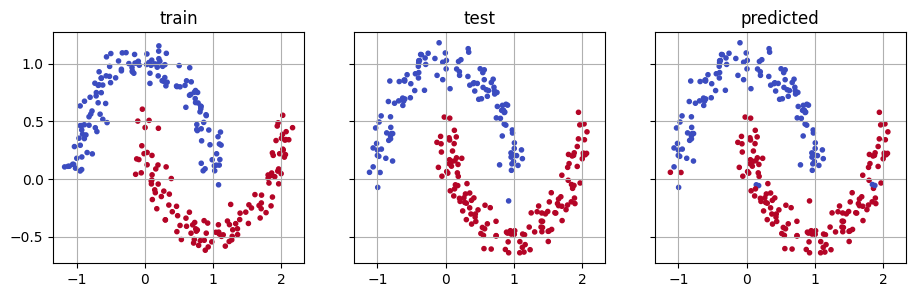

In [12]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,3, sharey=True, sharex=True, figsize=(11,3),)

ax[0].scatter(x=X_train[:,0],y=X_train[:,1],c=target_train,marker='.', cmap='coolwarm')
ax[0].set_title('train')
ax[0].grid()

ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test,marker='.', cmap='coolwarm')
ax[1].set_title('test')
ax[1].grid()

ax[2].scatter(x=X_test[:,0],y=X_test[:,1],c=predicted,marker='.', cmap='coolwarm' )
ax[2].set_title('predicted')
ax[2].grid()

In [13]:
# строим сетку 

n = 50 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-0.3, X_test[:,0].max()+0.3, n), 
    np.linspace( X_test[:,1].min()-0.3, X_test[:,1].max()+0.3, n)
) # узлы сетки
display( ( xx.shape, yy.shape ) )

xy = np.vstack([xx.ravel(),yy.ravel() ]).T # разворачиваем сетку 
display( xy.shape )

# plt.figure(figsize=(7,7))
# plt.scatter( x=xy[:,0], y=xy[:,1], s=1 )
# plt.show()

((50, 50), (50, 50))

(2500, 2)

Text(0.5, 1.0, 'test')

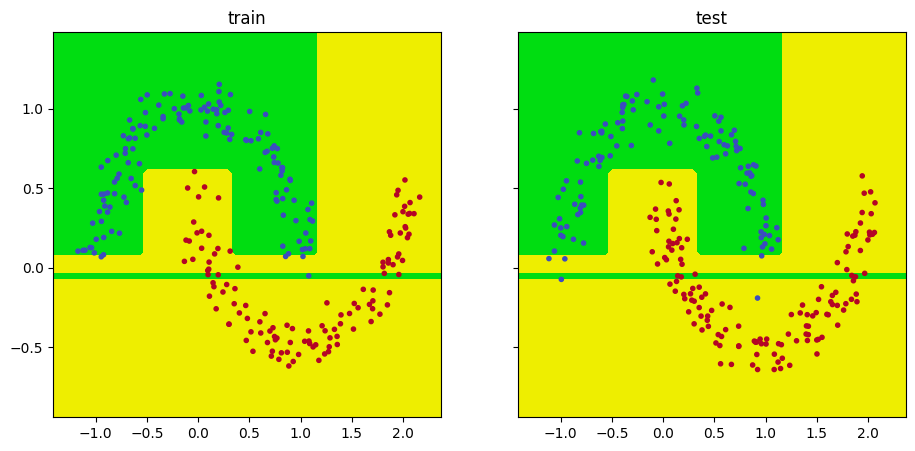

In [14]:
from matplotlib.colors import ListedColormap

predicted_xy = model.predict(xy).reshape(n,n) # вычисляем скор для каждого узла сетки

fig,ax = plt.subplots(1,2, sharey=True, sharex=True, figsize=(11,5),)

ax[0].contourf(xx, yy, predicted_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax[0].scatter(x=X_train[:,0],y=X_train[:,1],c=target_train,marker='.', cmap='coolwarm')
ax[0].set_title('train')
# ax[0].grid()

ax[1].contourf(xx, yy, predicted_xy, cmap=ListedColormap(['#0d1','#ee0']) )
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=target_test,marker='.', cmap='coolwarm')
ax[1].set_title('test')
# ax[1].grid()

## визуализация дерева

In [15]:
display( model.tree )

{'type': 'split',
 'feature': 1,
 'threshold': 0.0686136625893623,
 'info': 0.4773820183597862,
 '<': {'type': 'split',
  'feature': 1,
  'threshold': -0.07598946729068745,
  'info': 0.027725855965094012,
  '<': {'type': 'leaf', 'value': 1},
  '>': {'type': 'split',
   'feature': 1,
   'threshold': -0.04660378026601044,
   'info': 0.3227569588973983,
   '<': {'type': 'leaf', 'value': 0},
   '>': {'type': 'leaf', 'value': 1}}},
 '>': {'type': 'split',
  'feature': 0,
  'threshold': 1.1938395775351733,
  'info': 0.3189012733827811,
  '<': {'type': 'split',
   'feature': 1,
   'threshold': 0.6289998496630016,
   'info': 0.1126481731602561,
   '<': {'type': 'split',
    'feature': 0,
    'threshold': -0.509205949837644,
    'info': 0.19176610798010663,
    '<': {'type': 'leaf', 'value': 0},
    '>': {'type': 'split',
     'feature': 0,
     'threshold': 0.31934370137058016,
     'info': 0.9402859586706311,
     '<': {'type': 'leaf', 'value': 1},
     '>': {'type': 'leaf', 'value': 0}}},
  

In [16]:
class DecisionTreeFormatter:

    @classmethod
    def transform(self,tree):
        return self._tree2str(tree)

    # конвертируем дерево в ДНФ 
    @classmethod
    def _tree2str(cls,node,result=[],rule=[],condition=None):
        if not(condition is None): # если пороговое условие не пустое
            rule.append( '(x_%i %s %.2f)'%condition ) #  то докидываем его в правило
        if node['type']=='leaf':
            if node['value']==1: # берём только ветки к листьям positive
                # выполняем конъюнкцию всех условий ...
                # ... и докидываем правило в список дизъюнктов
                result.append( '\left['+'\\land '.join(rule)+'\\right]' )
            return result

        cls._tree2str( # двигаемся в ветку '>'
            node=node['>'],
            result=result,
            rule=rule.copy(),
            condition=(node['feature'],'>',node['threshold']) # создаём пороговое правило
        )

        cls._tree2str( # двигаемся в ветку '<'
            node=node['<'],
            result=result,
            rule=rule.copy(),
            condition=(node['feature'],'<',node['threshold']) # создаём пороговое правило
        )
        return  '$$'+'\n \\\\ \\lor '.join(result)+'$$' # собираем ДНФ, выполняем дизъюнкцию всех правил  

In [17]:
from IPython.display import Math 
# ДНФ - дизъюнктивная нормальная форма
display( Math(  DecisionTreeFormatter().transform(model.tree) ))

<IPython.core.display.Math object>

In [18]:
from collections import Counter
import graphviz

class DecisionTreePlotter:

    @classmethod
    def transform(self,tree,size='6,7'):
        dot = graphviz.Digraph()
        dot.attr(size=size)
        dot.node('root','start',color='yellow',style='filled')
        return self._plot_tree(tree,dot)

    @classmethod
    def _plot_tree(self,tree,dot,root='root',nc=Counter('node')):
        nc['node']+=1
        node='node%i'%(nc['node'])
        # node=tree['id']
        if tree['type']=='split':
            label = r'x[{feature}]>{threshold:.3f}\rinfo:{info:.3f}'.format(**tree)
            dot.node(node,label,color='lightgray',style='filled')
            self._plot_tree(tree=tree['>'],dot=dot,root=node,nc=nc)
            self._plot_tree(tree=tree['<'],dot=dot,root=node,nc=nc)
        else:
            label = '%i'%tree['value']
            c = ['lightskyblue','lightcoral'][tree['value']]
            dot.node(node,label,color=c,style='filled')
        dot.edge(root,node)
        return dot 

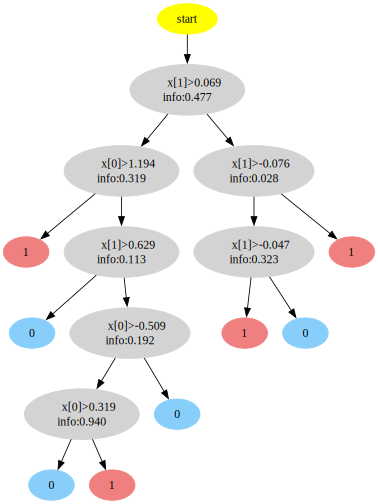

In [19]:
DecisionTreePlotter().transform(model.tree)